In [1]:
import torch
from torch import nn
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

# 网络中的网络（NiN）

## NiN块

- 解决之前卷积神经网络（例如AlexNet、VGG等）用全连接层表达输出导致缺失空间位置信息

- 一个卷积层后跟两个$1\times 1$卷积
    - 步幅1，无填充
    - 融合通道，起到全连接层的作用


- 从另一个角度看，$1\times1$卷积相当于把每个像素作为样本，把通道作为特征的全连接

<center><img src="../img/6_convolutional_neural_networks/1by1Conv.jpg" width=60%></center>

In [2]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    """定义NiN块"""
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

# NiN网络

## NiN架构

- 无全连接层
- 交替使用NiN块和步幅为2的最大汇聚层逐步减小高宽和增大通道数
- 最后使用全局平均汇聚层得到输出
- 其输出通道数是类别数

<center><img src='nin.png' width=60%></center>

- 全局平均汇聚层（Global Average Pool, GAP）
    - 汇聚核的大小与输入一样，转化为1个输出

<center><img src="../img/6_convolutional_neural_networks/gap.png" width=70%></center>

In [3]:
# 构建NiN网络

net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1), # 标签类别数是10
    nn.AdaptiveAvgPool2d((1, 1)), # 输出形状10*1*1
    nn.Flatten()) # 将四维的输出转成二维的输出，其形状为(批量大小,10)

```python
torch.nn.AdaptiveAvgPool2d(output_size)
```
- 根据输出形状自动设定核大小对输入数据进行平均汇聚
- `output_size`：输出形状，高$\times$宽，`tuple`或者`int`

```python
torch.nn.AdaptiveMaxPool2d(output_size)
```

- 查看每个块的输出形状

In [4]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


## 训练模型

In [ ]:
import sys
sys.path.append('/home/teaching/slides/deeplearning/3_linear_network')
sys.path.append('/home/teaching/slides/deeplearning/6_convolutional_neural_networks')
# 将load_data_fashion_mnist函数所在路径加入系统环境变量路径中

from softmax_regression_scratch import load_data_fashion_mnist, Accumulator, Animator, accuracy
from convolution_LeNet import train_ch6, try_gpu

loss 0.363, train acc 0.865, test acc 0.879
3212.2 examples/sec on cuda:0


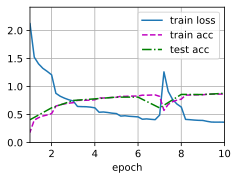

In [4]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

总结
- NiN块使用卷积层加两个1xl卷积层，
    - 后者对每个像素增加了非线性
- NiN使用全局平均汇聚层替代VGG和AlexNet中的全连接层
    - 不容易过拟合，更少的参数个数